In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Cleaning

In [44]:
df = pd.read_csv("./iboxx_usd_lq_ig_eod_underlyings_20160125.csv")
print(df.shape)
df['Seniority Level 1'] = df['Seniority Level 1'].replace('*', np.nan)
df['Seniority Level 2'] = df['Seniority Level 2'].replace('*', np.nan)

(1482, 129)


## Check the columns with null values

In [45]:
cols_with_na = [col for col in df.columns if df[col].isna().any()]
print(f"Totally {len(cols_with_na)} columns has null values\nThey are:")
print(cols_with_na)

num_na = [df[col].isnull().sum() for col in cols_with_na]
na_rate = [df[col].isnull().sum()/df.shape[0] for col in cols_with_na]

print("\n---The info of nans in dataset---")
print(f"{'Col':<20}\t{'num_na':<10}\t{'na_rate':<10}")
for col, n, rate in zip(cols_with_na, num_na, na_rate):
    print(f"{col:<20}\t{n:<10}\t{rate:<10.4f}")

Totally 10 columns has null values
They are:
['FX Version', 'Local 1', 'Local 2', 'Next Call Date', 'Simple Margin', 'Discount Margin', 'Index Ratio', 'Assumed Inflation', 'Seniority Level 1', 'Seniority Level 2']

---The info of nans in dataset---
Col                 	num_na    	na_rate   
FX Version          	1482      	1.0000    
Local 1             	1477      	0.9966    
Local 2             	1482      	1.0000    
Next Call Date      	1478      	0.9973    
Simple Margin       	1482      	1.0000    
Discount Margin     	1482      	1.0000    
Index Ratio         	1482      	1.0000    
Assumed Inflation   	1482      	1.0000    
Seniority Level 1   	1040      	0.7018    
Seniority Level 2   	1398      	0.9433    


These columns all have a very high rate of empty, pending to be removed.

# Check the columns with unique values or not

In [46]:
single_val_cols = [col for col in df.columns if df[col].nunique() == 1]
multi_val_cols = [col for col in df.columns if df[col].nunique() > 1]
full_na_cols = [col for col in df.columns if df[col].nunique() == 0]

print(len(single_val_cols))
print(len(multi_val_cols))
print(len(full_na_cols))

24
99
6


In [47]:
print(single_val_cols)

['Date', 'Fixing', 'Price Type', 'Index ISIN_CPi', 'Index ISIN_TRi', 'Index Name', 'Ex-Dividend', 'Coupon Adjustment', 'Current Redemption Payment', 'Redemption Factor', 'PIK Factor', 'Level 0', 'Level 2', 'Level 3', 'Seniority Level 3', 'Is Fixed to Float', 'Is Perpetual', 'Is Core index', 'Is Crossover', 'Is FRN', 'Is PIK', 'Is Zero Coupon', 'Is Sinking', '1-3 Years']


Since `Seniority Level 3` is in single_val_cols which is ought to removed, therefore, remove the high null columns `Seniority Level 1`, `Seniority Level 2` as well

## define the identification column

In [48]:
unique_value_cols = [col for col in df.columns if df[col].nunique() == df.shape[0]]
len(unique_value_cols)
# unique_value_cols

41

By looking at the meaning of columns, keep only ISIN from identification columns

## `Workout Date` is equal to `Final Maturity`?
since the reference Date is the same, the comparision also means comparing 

`Expected Remaining Life` and `Time To Maturity`

In [49]:
num_diff = sum(df['Expected Remaining Life'] != df['Time To Maturity'])
num_diff

0

choose one between: `Workout Date` and `Final Maturity`

`Expected Remaining Life` and `Time To Maturity`

# Handle `Next Coupon Date` into numerical schedule, just like `Expected Remaining Life` and `Time To Maturity`

`Next Coupon Date` -> `New Next Coupon Date`

In [50]:
reference_date = pd.to_datetime(df['Date'][0], format='%d/%m/%Y')
print(reference_date)

df['Next Coupon Date'] = pd.to_datetime(df['Next Coupon Date'], format='%d/%m/%Y')
df['New Next Coupon Date'] = (df['Next Coupon Date'] - reference_date).dt.days / 365.25

2016-01-25 00:00:00


# handle `Coupon Frequency`

In [51]:
df['Coupon Frequency'].value_counts()

Coupon Frequency
2    1480
4       1
1       1
Name: count, dtype: int64

In [93]:
df[df['Coupon Frequency'].isin([1, 4])].index

Index([79, 829], dtype='int64')

Since the class 4 and 1 is too little, drop them

# Bid_Ask_Spread = Ask Price - Bid Price?

In [52]:
# 计算 Bid_Ask_Spread
df['Calculated_Bid_Ask_Spread'] = df['Ask Price'] - df['Bid Price']

# 检查是否与原始 Bid_Ask_Spread 列一致
tolerance = 1e-4  # 设置误差范围
df['Bid_Ask_Spread_Check'] = np.isclose(df['Bid_Ask_Spread'], df['Calculated_Bid_Ask_Spread'], atol=tolerance)

# 输出不一致的行
inconsistent_rows = df[~df['Bid_Ask_Spread_Check']]
if len(inconsistent_rows)>=1:
    print("Inconsistent rows:")
    print(inconsistent_rows[['Bid Price', 'Ask Price', 'Bid_Ask_Spread', 'Calculated_Bid_Ask_Spread']])
else:
    print('Consistent! Bid_Ask_Spread = Ask Price - Bid Price')

# 检查 Bid_Ask_Spread 的正负关系
negative_spread = df[df['Bid_Ask_Spread'] < 0]
print("\nRows with negative Bid_Ask_Spread:")
print(negative_spread[['Bid Price', 'Ask Price', 'Bid_Ask_Spread']])

df = df.drop(columns = ['Calculated_Bid_Ask_Spread', 'Bid_Ask_Spread_Check'], errors='ignore')

Consistent! Bid_Ask_Spread = Ask Price - Bid Price

Rows with negative Bid_Ask_Spread:
Empty DataFrame
Columns: [Bid Price, Ask Price, Bid_Ask_Spread]
Index: []


# Index price meaning????

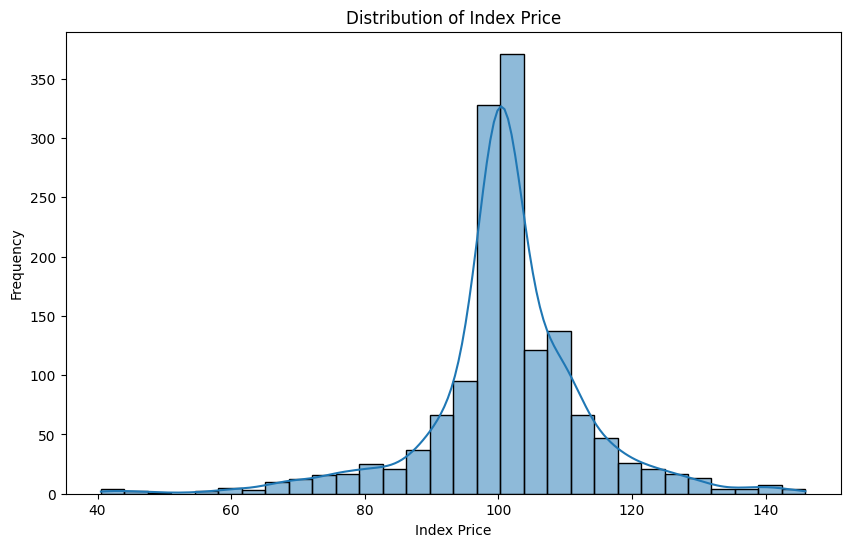

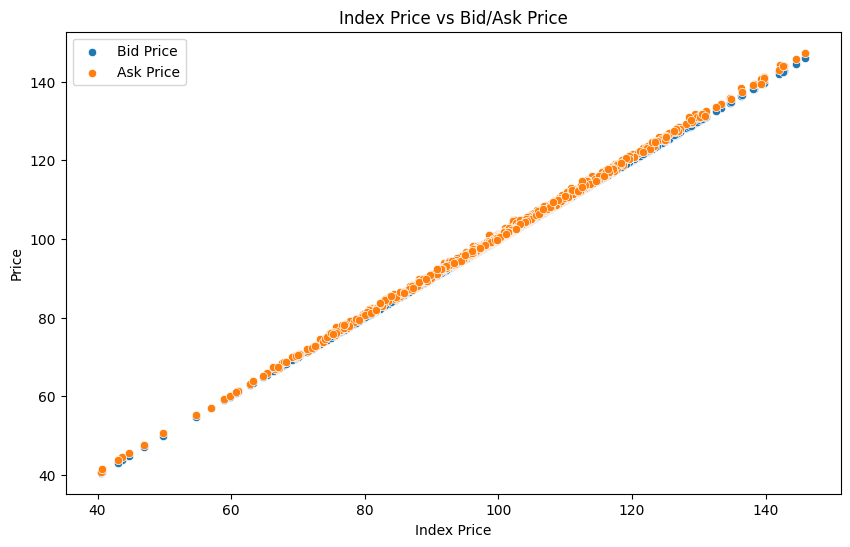

In [67]:
# 可视化 Index Price 的分布
plt.figure(figsize=(10, 6))
sns.histplot(df['Index Price'], kde=True, bins=30)
plt.title("Distribution of Index Price")
plt.xlabel("Index Price")
plt.ylabel("Frequency")
plt.show()

# 检查 Index Price 与 Bid Price 和 Ask Price 的关系
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Index Price', y='Bid Price', label='Bid Price')
sns.scatterplot(data=df, x='Index Price', y='Ask Price', label='Ask Price')
plt.title("Index Price vs Bid/Ask Price")
plt.xlabel("Index Price")
plt.ylabel("Price")
plt.legend()
plt.show()

Keep: Ask Price, Bid Price
Remove: Index Price

# why `accrued interest` != `coupon payment`

Accrued Interest 是应计利息，表示从上一次付息日到当前日期的累计利息

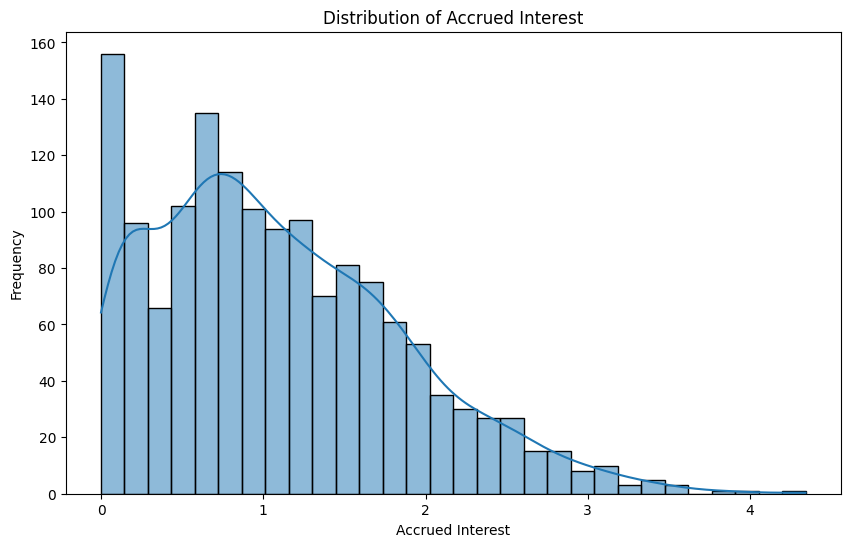

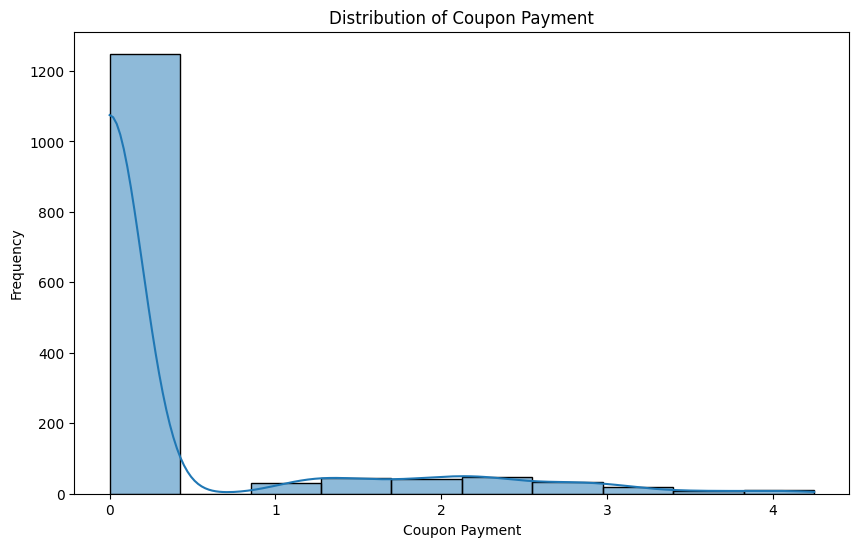

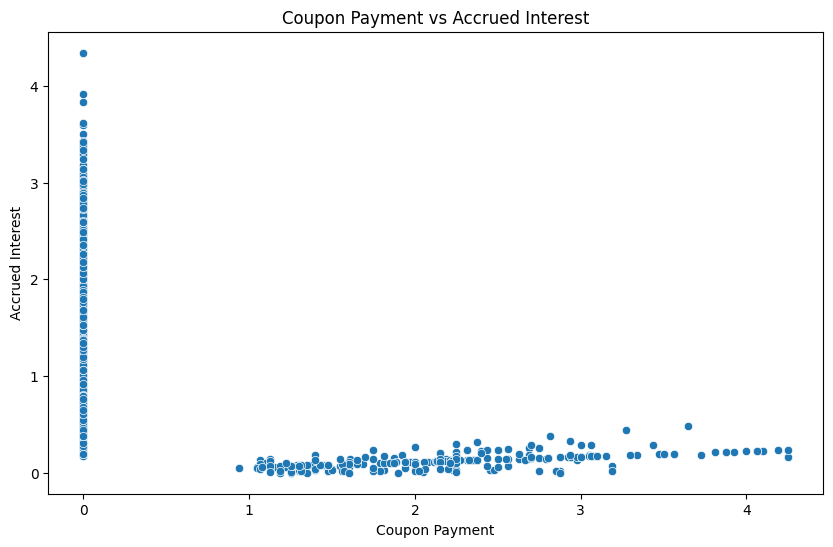

In [57]:
# 可视化 Accrued Interest 的分布
plt.figure(figsize=(10, 6))
sns.histplot(df['Accrued Interest'], kde=True, bins=30)
plt.title("Distribution of Accrued Interest")
plt.xlabel("Accrued Interest")
plt.ylabel("Frequency")
plt.show()

# 可视化 Coupon Payment  的分布
plt.figure(figsize=(10, 6))
sns.histplot(df['Coupon Payment'], kde=True, bins=10)
plt.title("Distribution of Coupon Payment")
plt.xlabel("Coupon Payment")
plt.ylabel("Frequency")
plt.show()


# 检查 Accrued Interest 与 Coupon Payment 的关系
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Coupon Payment', y='Accrued Interest')
plt.title("Coupon Payment vs Accrued Interest")
plt.xlabel("Coupon Payment")
plt.ylabel("Accrued Interest")
plt.show()

# Dirty Index Price ?= Index Price + Accrued Interest

In [69]:
# 计算 Dirty Index Price
df['Calculated_Dirty_Index_Price'] = df['Index Price'] + df['Accrued Interest']

# 检查是否与原始 Dirty Index Price 列一致
df['Dirty_Index_Price_Check'] = np.isclose(df['Dirty Index Price'], df['Calculated_Dirty_Index_Price'], atol=tolerance)

# 输出不一致的行
inconsistent_rows = df[~df['Dirty_Index_Price_Check']]
if len(inconsistent_rows)>=1:
    print("Inconsistent rows:")
    print(inconsistent_rows[['Index Price', 'Accrued Interest', 'Dirty Index Price', 'Calculated_Dirty_Index_Price']])
else:
    print("Consistent! Dirty Index Price = Index Price + Accrued Interest")

df = df.drop(columns = ['Calculated_Dirty_Index_Price', 'Dirty_Index_Price_Check'], errors='ignore')

Consistent! Dirty Index Price = Index Price + Accrued Interest


# Coupon Payment 的各种数值比例

In [62]:
df['Coupon Payment'].value_counts()

Coupon Payment
0.0000    1249
2.2500      10
1.1250       8
2.0000       8
1.9375       6
          ... 
1.4500       1
2.8500       1
2.9385       1
3.3380       1
3.1500       1
Name: count, Length: 116, dtype: int64

In [61]:
# 检查 Coupon Payment 为 0 的比例
zero_coupon_ratio = (df['Coupon Payment'] == 0).mean()
print(f"Percentage of Coupon Payment being 0: {zero_coupon_ratio * 100:.2f}%")

Percentage of Coupon Payment being 0: 84.28%


# Notional Amount vs Capped Notional Amount

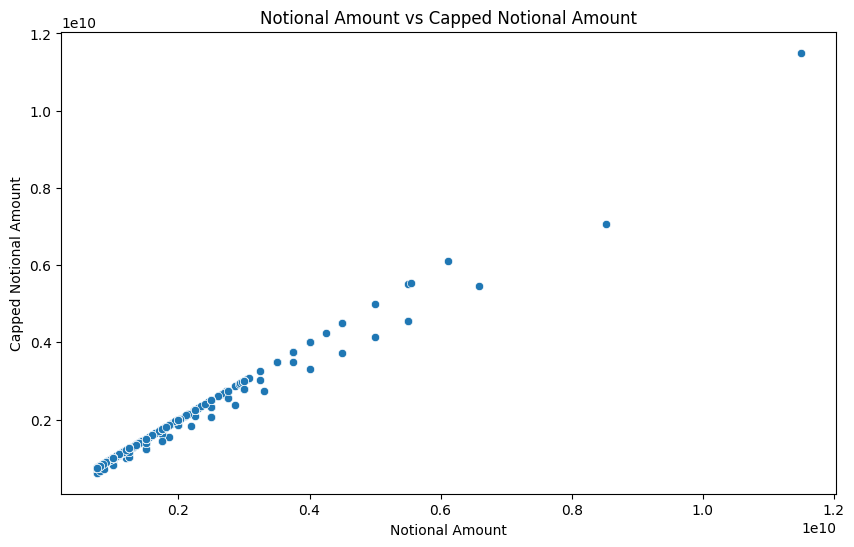

Capped Notional Amount is always <= Notional Amount: True


In [63]:
# 检查 Notional Amount 与 Capped Notional Amount 的关系
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Notional Amount', y='Capped Notional Amount')
plt.title("Notional Amount vs Capped Notional Amount")
plt.xlabel("Notional Amount")
plt.ylabel("Capped Notional Amount")
plt.show()

# 检查 Capped Notional Amount 是否总是小于或等于 Notional Amount
capped_check = (df['Capped Notional Amount'] <= df['Notional Amount']).all()
print(f"Capped Notional Amount is always <= Notional Amount: {capped_check}")

# Market Value vs Capped Market Value

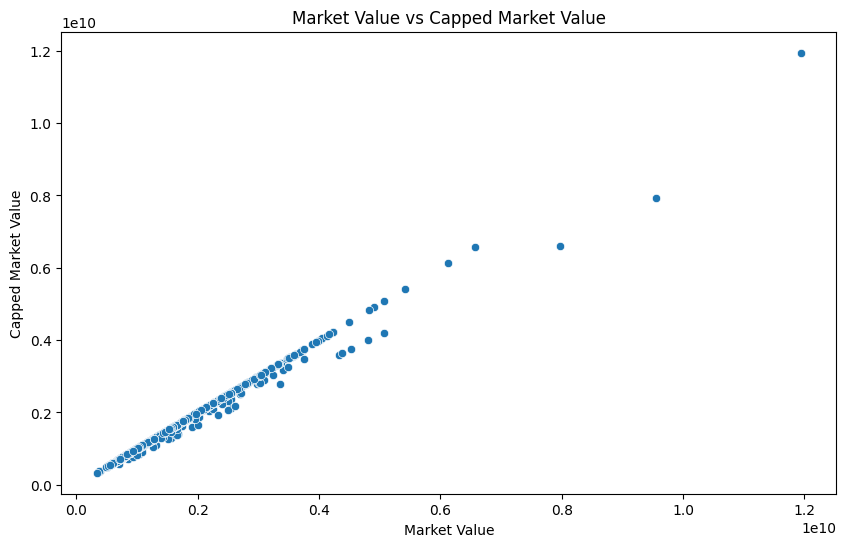

Capped Market Value is always <= Market Value: True


In [64]:
# 检查 Market Value 与 Capped Market Value 的关系
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Market Value', y='Capped Market Value')
plt.title("Market Value vs Capped Market Value")
plt.xlabel("Market Value")
plt.ylabel("Capped Market Value")
plt.show()

# 检查 Capped Market Value 是否总是小于或等于 Market Value
capped_check = (df['Capped Market Value'] <= df['Market Value']).all()
print(f"Capped Market Value is always <= Market Value: {capped_check}")

# Cash Payment vs Capped Cash Payment

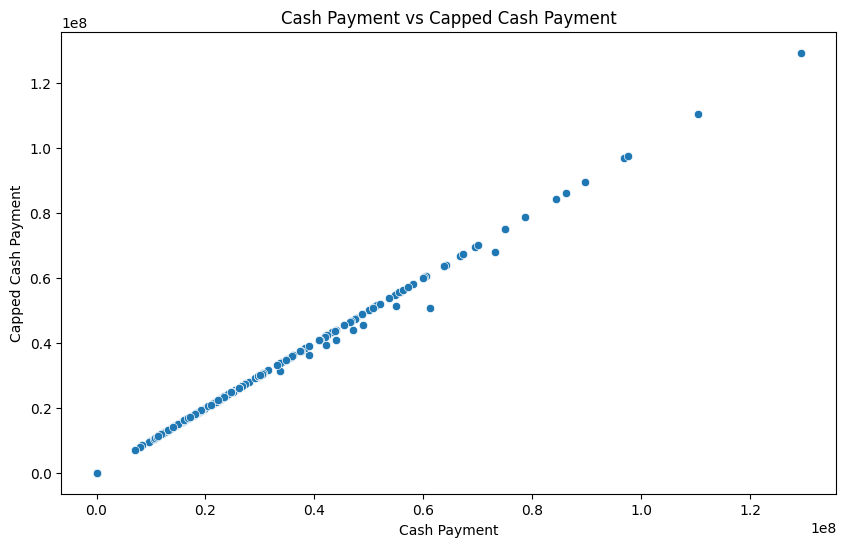

Capped Cash Payment is always <= Cash Payment: True


In [65]:
# 检查 Cash Payment 与 Capped Cash Payment 的关系
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Cash Payment', y='Capped Cash Payment')
plt.title("Cash Payment vs Capped Cash Payment")
plt.xlabel("Cash Payment")
plt.ylabel("Capped Cash Payment")
plt.show()

# 检查 Capped Cash Payment 是否总是小于或等于 Cash Payment
capped_check = (df['Capped Cash Payment'] <= df['Cash Payment']).all()
print(f"Capped Cash Payment is always <= Cash Payment: {capped_check}")

I think `Cash Payment` and `Capped Cash Payment` are identical? keep one of these?

# `Street Yield` == `Semi-Annual Yield`?

In [72]:
sum_diff = sum(df['Street Yield'] !=df['Semi-Annual Yield'])
diff_row = df.loc[df['Street Yield'] !=df['Semi-Annual Yield']]
diff_row[['Street Yield', 'Semi-Annual Yield']]

,Street Yield,Semi-Annual Yield
79,3.319907,3.333684
829,4.417773,4.370030


In [97]:
sum_diff = sum(df['Street Yield to Maturity'] !=df['Semi-Annual Yield to Maturity'])
diff_row = df.loc[df['Street Yield to Maturity'] !=df['Semi-Annual Yield to Maturity']]
diff_row[['Street Yield to Maturity', 'Semi-Annual Yield to Maturity']]

,Street Yield to Maturity,Semi-Annual Yield to Maturity
79,3.319907,3.333684
829,4.417773,4.370030


almost the same, only two different, remove these rows or?

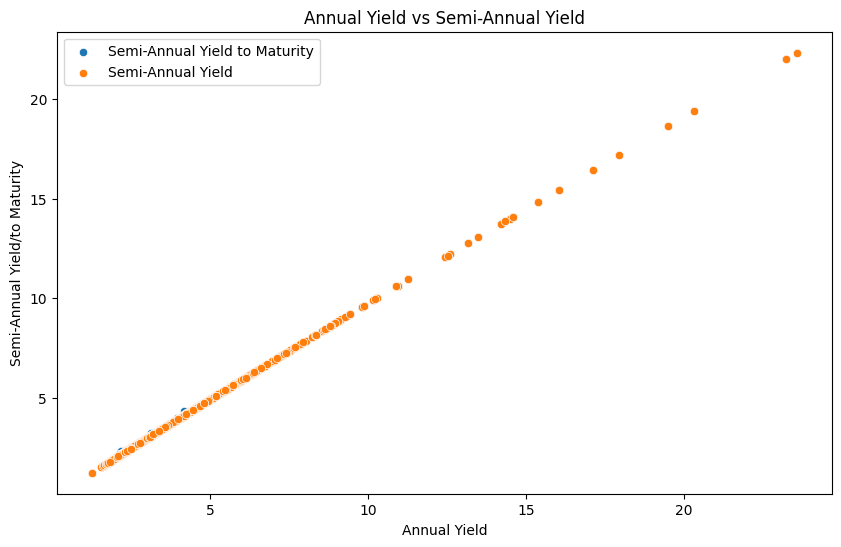

In [77]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Yield', y='Semi-Annual Yield to Maturity', label = 'Semi-Annual Yield to Maturity')
sns.scatterplot(data=df, x='Annual Yield', y='Semi-Annual Yield', label = 'Semi-Annual Yield')
plt.title("Annual Yield vs Semi-Annual Yield")
plt.xlabel("Annual Yield")
plt.ylabel("Semi-Annual Yield/to Maturity")
plt.show()


identical, keep one of it?

Remove: Semi-Annual Yield, Semi-Annual Yield to Maturity?
complex here, need more domain knowlege decision

Group 5 (6 features):
* Keep: Annual Yield, Annual Yield to Maturity, Street Yield, Street Yield to Maturity
* Remove: Semi-Annual Yield, Semi-Annual Yield to Maturity
* Removal reasons:
    - Semi-Annual Yield can be removed because it is highly correlated with Annual Yield (r = 0.999882)
    - Semi-Annual Yield to Maturity can be removed because it is highly correlated with Annual Yield (r = 0.999870)

# Duration?!

Group 6 (7 features):
    * Keep: Annual Modified Duration, Annual Modified Duration to Maturity, Duration, Street Modified Duration, Street Modified Duration to Maturity
    * Remove: Semi-Annual Modified Duration, Semi-Annual Modified Duration to Maturity
    * Removal reasons:
      - Semi-Annual Modified Duration can be removed because it is highly correlated with Annual Modified Duration (r = 0.999907)
      - Semi-Annual Modified Duration to Maturity can be removed because it is highly correlated with Annual Modified Duration (r = 0.999721)

# Street Modified Duration vs Semi-Annual Modified Duration vs Street Modified Duration to Maturity vs Semi-Annual Modified Duration to Maturity

In [83]:
sum_diff = sum(df['Street Modified Duration'] !=df['Semi-Annual Modified Duration'])
diff_row = df.loc[df['Street Modified Duration'] !=df['Semi-Annual Modified Duration']]
diff_row[['Street Modified Duration', 'Semi-Annual Modified Duration']]

,Street Modified Duration,Semi-Annual Modified Duration
79,6.498163,6.444674
829,16.219656,16.574058


In [100]:
sum_diff = sum(df['Street Modified Duration to Maturity'] !=df['Semi-Annual Modified Duration to Maturity'])
diff_row = df.loc[df['Street Modified Duration to Maturity'] !=df['Semi-Annual Modified Duration to Maturity']]
diff_row[['Street Modified Duration to Maturity', 'Semi-Annual Modified Duration to Maturity']]

,Street Modified Duration to Maturity,Semi-Annual Modified Duration to Maturity
79,6.498163,6.444674
829,16.219656,16.574058


In [81]:
df.iloc[[79, 829]][['Street Modified Duration', 'Semi-Annual Modified Duration', 'Street Modified Duration to Maturity', 'Semi-Annual Modified Duration to Maturity']]

,Street Modified Duration,Semi-Annual Modified Duration,Street Modified Duration to Maturity,Semi-Annual Modified Duration to Maturity
79,6.498163,6.444674,6.498163,6.444674
829,16.219656,16.574058,16.219656,16.574058


# Convexity

In [88]:
sum_diff = sum(df['Street Convexity'] !=df['Semi-Annual Convexity'])
diff_row = df.loc[df['Street Convexity'] !=df['Semi-Annual Convexity']]
diff_row[['Street Convexity', 'Semi-Annual Convexity']]

,Street Convexity,Semi-Annual Convexity
79,48.221421,49.015577
829,381.860253,390.620145


In [103]:
sum_diff = sum(df['Street Convexity to Maturity'] !=df['Semi-Annual Convexity to Maturity'])
diff_row = df.loc[df['Street Convexity to Maturity'] !=df['Semi-Annual Convexity to Maturity']]
diff_row[['Street Convexity to Maturity', 'Semi-Annual Convexity to Maturity']]

,Street Convexity to Maturity,Semi-Annual Convexity to Maturity
79,48.221421,49.015577
829,381.860253,390.620145


# Return

Group 13 (3 features):
* Keep: Quarter-to-Date Return
* Remove: Month-to-Date Return, Year-to-Date Return
* Removal reasons:
    - Month-to-Date Return can be removed because it is practically identical to Quarter-to-Date Return (MAD: 0.000062)
    - Year-to-Date Return can be removed because it is 100% identical to Quarter-to-Date Return

In [112]:
sum_diff = sum(df['Quarter-to-Date Return'] !=df['Month-to-Date Return'])
print(sum_diff)
print("different rate:", sum_diff/df.shape[0]*100)

22
different rate: 1.484480431848853


In [107]:
sum_diff = sum(df['Quarter-to-Date Return'] !=df['Year-to-Date Return'])
diff_row = df.loc[df['Quarter-to-Date Return'] !=df['Year-to-Date Return']]
diff_row[['Quarter-to-Date Return', 'Year-to-Date Return']]

,Quarter-to-Date Return,Year-to-Date Return


`Quarter-to-Date Return` and `Year-to-Date Return` are completely the same, keep on of it

# Summary of data cleaning


Import finding! row 79 and 829 (also their class(4 and 1) is too rare in `Coupon Frequency`!

if drop these two rows, below column parirs are completely the same!

- 'Street Yield', 'Semi-Annual Yield'
- 'Street Yield to Maturity', 'Semi-Annual Yield to Maturity'
- 'Street Modified Duration', 'Semi-Annual Modified Duration'
- 'Street Modified Duration to Maturity', 'Semi-Annual Modified Duration to Maturity'
- 'Street Convexity', 'Semi-Annual Convexity'
- 'Street Convexity to Maturity', 'Semi-Annual Convexity to Maturity'

In [113]:
pending_col_to_drop = ['Semi-Annual Yield', 'Semi-Annual Yield to Maturity', 'Semi-Annual Modified Duration', 'Semi-Annual Modified Duration to Maturity', 'Semi-Annual Convexity', 'Semi-Annual Convexity to Maturity']

- columns to drop:
    - `cols_with_na`, null_rate really high, >70%
    - `single_val_cols`
    - choose one between: `Workout Date` and `Final Maturity` cause they are the same
    - choose one between: `Expected Remaining Life` and `Time To Maturity` cause they are the same
    - Index Price
    - choose one between: `Cash Payment` and `Capped Cash Payment` since identical?
    - choose one between: `Quarter-to-Date Return` and `Year-to-Date Return` cause they are the same
    - `Month-to-Date Return` can be removed because it is practically identical to Quarter-to-Date Return 
- identification column
    - `ISIN`
- drop the rows since:
    - the class 4 and 1 is too rare in `Coupon Frequency`
- add new feature:
    - `New Next Coupon Date`


In [ ]:
# pending_col_to_drop.extend(['Final Maturity', 'Time To Maturity', 'Capped Cash Payment', 'Year-to-Date Return', 'Month-to-Date Return'])

# final decision?

In [ ]:
# Keep only ISIN from identification columns
df = df.drop(columns=['CUSIP', 'Identifier'], errors='ignore')

print(single_val_cols)
print(cols_with_na)

# Remove the rows 
df = df[~df['Coupon Frequency'].isin([4, 1])]

# Remove the unnecessary columns
df = df.drop(columns=single_val_cols, errors='ignore')
df = df.drop(columns=cols_with_na, errors='ignore')
# df = df.drop(columns=pending_col_to_drop, errors='ignore')

# Save cleaned data
print("After cleaning, the shape is:", df.shape)
cleaned_file_path = "lh_cleaned_iboxx_usd_lq_ig_eod.csv"
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset saved to {cleaned_file_path}")

['Date', 'Fixing', 'Price Type', 'Index ISIN_CPi', 'Index ISIN_TRi', 'Index Name', 'Ex-Dividend', 'Coupon Adjustment', 'Current Redemption Payment', 'Redemption Factor', 'PIK Factor', 'Level 0', 'Level 2', 'Level 3', 'Seniority Level 3', 'Is Fixed to Float', 'Is Perpetual', 'Is Core index', 'Is Crossover', 'Is FRN', 'Is PIK', 'Is Zero Coupon', 'Is Sinking', '1-3 Years']
['FX Version', 'Local 1', 'Local 2', 'Next Call Date', 'Simple Margin', 'Discount Margin', 'Index Ratio', 'Assumed Inflation', 'Seniority Level 1', 'Seniority Level 2']
After cleaning, the shape is: (1482, 93)
Cleaned dataset saved to lh_cleaned_iboxx_usd_lq_ig_eod.csv
